# Week 10

This week, we will cover three new ideas:

* The last of the relatively novel CNNs, the ResNet (He et al. 2015, https://arxiv.org/abs/1512.03385), which allows for deeper networks without gradients vanishing by implementing "skip-connections" that pass data forward in networks, skipping certain layers.

* Ensemble learning -- the idea that we can train several *different* neural networks on a dataset and let them *vote* on inferences.

* Transfer learning -- the astounding idea that we can *transfer* a trained neural network's performance on its dataset an *entirely different* dataset.

# Lecture 16 - ResNets and Ensemble Learning

## ResNets

Let's implement a ResNet here. We will write a function to create residual modules first and then iteratively construct the architecture to save some repetition.

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report

In [2]:
class ResNet:
    def residual_module(data, K, stride, channelsDim, reduce = False, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9):
        shortcut = data
        
        # 1x1 CONVs
        bn1 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(data)
        act1 = Activation('relu')(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act1)
        
        # 3x3 CONVs
        bn2 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = 'same', use_bias = False, kernel_regularizer = l2(reg))(act2)
        
        # 1x1 CONVs
        bn3 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv2)
        act3 = Activation('relu')(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act3)
        
        # if we reduce the spatial size, apply a CONV layer to the shortcut
        if reduce:
            shortcut = Conv2D(K, (1, 1), strides = stride, use_bias = False, kernel_regularizer = l2(reg))(act1)
            
        # add the shortcut and the final CONV
        x = add([conv3, shortcut])
        
        return x
    
    def build(width, height, depth, classes, stages, filters, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9, dataset='cifar'):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        if backend.image_data_format() == 'channels_first':
            inputShape = (depth, height, width)
            channelsDim = 1
            
        # set the input and apply BN
        inputs = Input(shape = inputShape)
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(inputs)
        
        if dataset == 'cifar':
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = 'same',
                       kernel_regularizer = l2(reg))(x)
        
        # loop over the number of stages
        for counter in range(0, len(stages)):
            # initialize the stride
            if counter == 0:
                stride = (1, 1)
            else:
                stride = (2, 2)
                    
            # apply a residual module to reduce the spatial dimension of the image volume
            x = ResNet.residual_module(x, filters[counter + 1], stride, channelsDim, reduce = True, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
            
            # loop over the number of layers in the current stage
            for j in range(0, stages[counter] - 1):
                # apply a residual module
                x = ResNet.residual_module(x, filters[counter + 1], (1, 1), channelsDim, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
                    
        # apply BN -> ACT -> POOL
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(x)
        x = Activation('relu')(x)
        x = AveragePooling2D((8, 8))(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer = l2(reg))(x)
        x = Activation('softmax')(x)
        
        # create the model
        model = Model(inputs, x, name = 'ResNet')
        
        # return the model
        return model

### ResNet on CIFAR-10

Let's test it on CIFAR-10 with data augmentation (width shift, height shift, and horizontal flips).

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
[INFO] training network...
Epoch 1/100
390/390 [==============================] - 42s 98ms/step - loss: 1.9638 - accuracy: 0.4437 - val_loss: 1.8061 - val_accuracy: 0.4882
Epoch 2/100
390/390 [==============================] - 37s 96ms/step - loss: 1.5243 - accuracy: 0.6035 - val_loss: 1.4877 - val_accuracy: 0.6171
Epoch 3/100
390/390 [==============================] - 37s 96ms/step - loss: 1.2968 - accuracy: 0.6809 - val_loss: 1.2972 - val_accuracy: 0.6824
Epoch 4/100
390/390 [==============================] - 37s 96ms/step - loss: 1.1377 - accuracy: 0.7348 - val_loss: 1.1144 - val_accuracy: 0.7388
Epoch 5/100
390/390 [==============================] - 37s 96ms/step - loss: 1.0309 - accuracy: 0.7676 - val_loss: 1.0918 - val_accuracy: 0.7457
Epoch 6/100
390/390 [==============================] - 37s 96ms/step - loss: 0.9556 - accuracy: 0.7894 - val_loss: 1.1763 - val_accuracy: 0.7397
Epoch 7/100
390/390 [========================

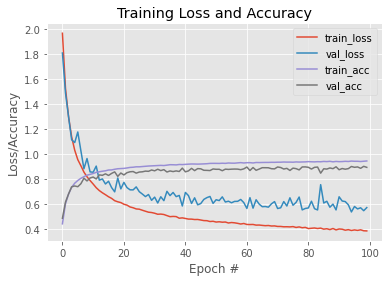

In [24]:
# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to one-hot vectors
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# create a data augmentation pipeline
aug = ImageDataGenerator(width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         horizontal_flip = True,
                         fill_mode="nearest")

print("[INFO] compiling model...")
opt = Adam()
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

print("[INFO] training network...")
H = model.fit(aug.flow(trainX, trainY, batch_size=128),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 128,
              epochs=100,
              verbose=1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### ResNet Experiment 2: Data Augmentation and a Learning Rate Scheduler

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
[INFO] training network...
Epoch 1/100
390/390 [==============================] - 40s 95ms/step - loss: 2.2019 - accuracy: 0.3508 - val_loss: 1.9210 - val_accuracy: 0.4652
Epoch 2/100
390/390 [==============================] - 36s 92ms/step - loss: 1.8316 - accuracy: 0.4977 - val_loss: 1.8254 - val_accuracy: 0.5008
Epoch 3/100
390/390 [==============================] - 36s 92ms/step - loss: 1.6504 - accuracy: 0.5730 - val_loss: 1.5737 - val_accuracy: 0.6063
Epoch 4/100
390/390 [==============================] - 36s 92ms/step - loss: 1.5067 - accuracy: 0.6254 - val_loss: 1.5280 - val_accuracy: 0.6260
Epoch 5/100
390/390 [==============================] - 36s 92ms/step - loss: 1.3890 - accuracy: 0.6682 - val_loss: 1.4121 - val_accuracy: 0.6626
Epoch 6/100
390/390 [==============================] - 36s 93ms/step - loss: 1.2933 - accuracy: 0.7028 - val_loss: 1.2957 - val_accuracy: 0.7061
Epoch 7/100
390/390 [========================

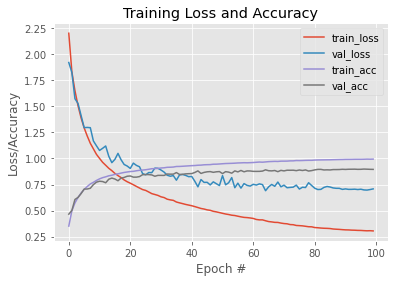

In [27]:
numberOfEpochs = 100
initialLearningRate = 0.1

# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to one-hot vectors
trainY = to_categorical(trainY)
testY = to_categorical(testY)

aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode="nearest")

print("[INFO] compiling model...")
opt = SGD(lr = initialLearningRate)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

# print a model summary
#print(model.summary())

print("[INFO] training network...")

# code for a learning rate scheduler
def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha

callbacks = [LearningRateScheduler(polynomial_decay)]

H = model.fit(aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 128, epochs=numberOfEpochs,
              callbacks = callbacks,
              verbose=1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Results are good but a little underwhelming here--according to Identity Mappings in Deep Residual Networks (He et. al., 2016, https://arxiv.org/abs/1603.05027), a similar approach can reach about 94% accuracy, but this is with a much deeper net.

<AxesSubplot:>

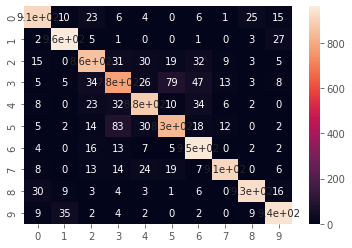

In [30]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

heatmap(confusion_matrix(testY, predictedY), annot = True)

Error analysis shows class 3 (cat) is getting mixed up with class 5 (dog), which makes some sense since both are relatively small, furry animals.

## Ensemble Methods

A common technique used with classification methods (both non-neural and neural) is to take an ensemble of models and combine them to make classification decisions. For example, we could run 5 neural nets, each with comparable accuracy overall, and classify each datapoint based on the majority vote of the 5 networks.

(This also applies to regression problems if we do some sort of averaging of the predictions.)

Ensembling almost always improves results compared to using just one net because different nets have unique talents and may make errors on different datapoints, but, assuming all the nets have good accuracy, they are typically correct, so these mistakes are frequently restricted to just a minority of models.

Let's bring in a few (mini) modern CNN achitectures we wrote in the past to use for some ensembling. Note that any architecture would work for the forthcoming experiments, but the following nets can run relatively quickly.

First, we import some things we need.

In [3]:
# basic packages
import cv2
import glob
import imutils
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

# sklearn functions
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# keras functions
from tensorflow.keras import backend
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

### MiniVGGNet

In [4]:
# create a class for a mini version of VGGNet (Simonyan and Zisserman, 2015)
class MiniVGGNet:
    def build(height, width, depth, classes):
        # create the model and name it MiniVGGNet
        model = Sequential(name = 'MiniVGGNet')
                
        # convolutional layer with 32 3x3 feature maps
        model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # convolutional layer with 32 3x3 feature maps
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # 2x2 max pooling layer with stride 2x2
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # convolutional layer with 64 3x3 feature maps
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # convolutional layer with 64 3x3 feature maps
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # 2x2 max pooling layer with stride 2x2
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # flatten the activations from a square to a vector
        model.add(Flatten())
        
        # fully-connected layer
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fully-connected layer with softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the model
        return model

### MiniGoogLeNet

In [5]:
class MiniGoogLeNet:
    def convolution_module(x, K, kX, kY, stride, channelsDim, padding="same"):
        # create a CONV -> BN -> RELU sequence
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
        x = BatchNormalization(axis = channelsDim)(x)
        x = Activation('relu')(x)
        
        # return the output
        return x
    
    def inception_module(x, numberOf1x1Kernels, numberOf3x3Kernels, channelsDim):
        # define two "parallel" convolutions of size 1x1 and 3x3 concatenated across the channels dimension
        convolution_1x1 = MiniGoogLeNet.convolution_module(x, numberOf1x1Kernels, 1, 1, (1, 1), channelsDim)
        convolution_3x3 = MiniGoogLeNet.convolution_module(x, numberOf3x3Kernels, 3, 3, (1, 1), channelsDim)
        x = concatenate([convolution_1x1, convolution_3x3], axis = channelsDim)
        
        return x
        
    def downsample_module(x, K, channelsDim):
        # define a CONV and POOL and then concatenate across the channels dimension
        convolution_3x3 = MiniGoogLeNet.convolution_module(x, K, 3, 3, (2, 2), channelsDim, padding = 'valid')
        pool = MaxPooling2D((3, 3), strides = (2, 2))(x)
        x = concatenate([convolution_3x3, pool], axis = channelsDim)
        
        return x
    
    def build(width, height, depth, classes):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        if backend.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            channelsDim = 1
        
        # define the model input and first CONV module
        inputs = Input(shape = inputShape)
        x = MiniGoogLeNet.convolution_module(inputs, 96, 3, 3, (1, 1), channelsDim)
        
        # two inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 32, 32, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, channelsDim)
        x = MiniGoogLeNet.downsample_module(x, 80, channelsDim)
        
        # four inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 112, 48, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, channelsDim)
        x = MiniGoogLeNet.downsample_module(x, 96, channelsDim)
        
        # two inception modules followed by global POOL and dropout
        x = MiniGoogLeNet.inception_module(x, 176, 160, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, channelsDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation('softmax')(x)
        
        # create a model
        model = Model(inputs, x, name='MiniGoogLeNet')
        
        # return the model
        return model

### ResNet

In [6]:
class ResNet:
    def residual_module(data, K, stride, channelsDim, reduce = False, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9):
        shortcut = data
        
        # 1x1 CONVs
        bn1 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(data)
        act1 = Activation('relu')(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act1)
        
        # 3x3 CONVs
        bn2 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = 'same', use_bias = False, kernel_regularizer = l2(reg))(act2)
        
        # 1x1 CONVs
        bn3 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv2)
        act3 = Activation('relu')(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act3)
        
        # if we reduce the spatial size, apply a CONV layer to the shortcut
        if reduce:
            shortcut = Conv2D(K, (1, 1), strides = stride, use_bias = False, kernel_regularizer = l2(reg))(act1)
            
        # add the shortcut and the final CONV
        x = add([conv3, shortcut])
        
        return x
    
    def build(width, height, depth, classes, stages, filters, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9, dataset='cifar'):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        if backend.image_data_format() == 'channels_first':
            inputShape = (depth, height, width)
            channelsDim = 1
            
        # set the input and apply BN
        inputs = Input(shape = inputShape)
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(inputs)
        
        if dataset == 'cifar':
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = 'same',
                       kernel_regularizer = l2(reg))(x)
        
        # loop over the number of stages
        for counter in range(0, len(stages)):
            # initialize the stride
            if counter == 0:
                stride = (1, 1)
            else:
                stride = (2, 2)
                    
            # apply a residual module to reduce the spatial dimension of the image volume
            x = ResNet.residual_module(x, filters[counter + 1], stride, channelsDim, reduce = True, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
            
            # loop over the number of layers in the current stage
            for j in range(0, stages[counter] - 1):
                # apply a residual module
                x = ResNet.residual_module(x, filters[counter + 1], (1, 1), channelsDim, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
                    
        # apply BN -> ACT -> POOL
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(x)
        x = Activation('relu')(x)
        x = AveragePooling2D((8, 8))(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer = l2(reg))(x)
        x = Activation('softmax')(x)
        
        # create the model
        model = Model(inputs, x, name = 'ResNet')
        
        # return the model
        return model

### Training Ensembles

Now, let's look at some ensembling methods. In the simplest case, we train several nets and average the classifications at the end. If the nets have similar performance, but make mistakes on *different* examples, this approach improves performance in most cases.

**Quick GPU Check**: Before we start training models, let's check our GPU resources. If you have a GPU set up to work with TensorFlow, its name will be output and it will be used in training. If not, none will be output and your training will use your CPU.

In [7]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print("Num GPUs Available: ", numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

Num GPUs Available:  2
/device:GPU:0
device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


### Training with the Same Hyperparameters Multiple Times

Next, let's train several MiniGoogLeNets (small versions of Inception nets) on CIFAR-10.

In [17]:
# load cifar10 data
((trainX, trainY), (testX, testY)) = cifar10.load_data()
labelNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# preprocess data
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

# create an image generator for data augmentation with random shifting, rotation, and horizontal flips
aug = ImageDataGenerator(rotation_range = 10,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         horizontal_flip = True,
                         fill_mode = 'nearest')

In [21]:
numberOfModels = 4
epochs = 50

for i in range(numberOfModels):
    print('Net', i, 'is being trained...')
    
    # choose the optimizer
    opt = Adam()
    
    # compile the model
    model = MiniGoogLeNet.build(width = 32, height = 32, depth = 3, classes = 10)
    
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
    
    # train the model
    H = model.fit(aug.flow(trainX, trainY, batch_size = 64),
                  validation_data = (testX, testY),
                  epochs = epochs,
                  steps_per_epoch = len(trainX) // 64,
                  verbose = 1)
    
    # save the model
    p = ['models1', 'model_{}.model'.format(i)]
    model.save(os.path.sep.join(p))
    
    # evaluate the network
    predictions = model.predict(testX, batch_size=64)
    report = classification_report(testY.argmax(axis=1),
                                   predictions.argmax(axis=1),
                                   target_names=labelNames)
    
    # save the classification report to file
    p = ['output1', 'model_{}.txt'.format(i)]
    f = open(os.path.sep.join(p), "w")
    f.write(report)
    f.close()
    
    # plot the training loss and accuracy
    p = ['output1', 'model_{}.png'.format(i)]
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
    plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
    plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
    plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
    # add labels and legend
    plt.title('Training Loss and Accuracy for model {}'.format(i))
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    
    # save graphs
    plt.savefig(os.path.sep.join(p))
    plt.close()

Net 0 is being trained...
Epoch 1/50
781/781 [==============================] - 19s 23ms/step - loss: 1.3371 - accuracy: 0.5172 - val_loss: 1.2020 - val_accuracy: 0.5743
Epoch 2/50
781/781 [==============================] - 17s 22ms/step - loss: 0.9042 - accuracy: 0.6838 - val_loss: 1.0691 - val_accuracy: 0.6448
Epoch 3/50
781/781 [==============================] - 17s 22ms/step - loss: 0.7345 - accuracy: 0.7456 - val_loss: 0.8435 - val_accuracy: 0.7119
Epoch 4/50
781/781 [==============================] - 17s 22ms/step - loss: 0.6302 - accuracy: 0.7827 - val_loss: 0.8261 - val_accuracy: 0.7138
Epoch 5/50
781/781 [==============================] - 17s 22ms/step - loss: 0.5671 - accuracy: 0.8046 - val_loss: 0.6849 - val_accuracy: 0.7735
Epoch 6/50
781/781 [==============================] - 17s 22ms/step - loss: 0.5118 - accuracy: 0.8244 - val_loss: 1.0000 - val_accuracy: 0.7098
Epoch 7/50
781/781 [==============================] - 17s 22ms/step - loss: 0.4692 - accuracy: 0.8426 - val_lo

Next, we test the ensemble.

In [23]:
# construct the path used to collect the models then initialize the
# models list
modelPaths = os.path.sep.join(['models1', '*.model'])
modelPaths = list(glob.glob(modelPaths))
models = []

# loop over the model paths, loading the model, and adding it to
# the list of models
for (i, modelPath) in enumerate(modelPaths):
    print('Loading model {}/{}'.format(i + 1, len(modelPaths)))
    models.append(load_model(modelPath))

# initialize the list of predictions
print('Evaluating ensemble...')
predictions = []

# loop over the models
for model in models:
    # use the current model to make predictions on the testing data,
    # then store these predictions in the aggregate predictions list
    predictions.append(model.predict(testX, batch_size=64))

# average the probabilities across all model predictions
predictions = np.average(predictions, axis=0)

# show a classification report
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

Loading model 1/5
Loading model 2/5
Loading model 3/5
Loading model 4/5
Loading model 5/5
Evaluating ensemble...
              precision    recall  f1-score   support

    airplane       0.94      0.93      0.94      1000
  automobile       0.96      0.97      0.97      1000
        bird       0.90      0.91      0.90      1000
         cat       0.84      0.86      0.85      1000
        deer       0.93      0.93      0.93      1000
         dog       0.90      0.87      0.88      1000
        frog       0.94      0.96      0.95      1000
       horse       0.98      0.93      0.95      1000
        ship       0.97      0.96      0.96      1000
       truck       0.92      0.96      0.94      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



Here, we actually ran the network with the very same hyperparameters 5 times and found that the best ones performed at around **90%**, but the ensemble of all 5 averaged together reseults in a higher accuracy rate of **93%**!

Mathematically, what has happened is likely that the different nets converged to *different* local minima so that, while their individual accuracy rates were all similar, the different nets were, apparently misclassifying *different* test examples, resulting in the average classification of all the models being correct more frequently than any individual net.

### Ensemble Training with Different Nets

It stands to reason that nets that are more significantly different are more likely to make significantly different classification mistakes since they may work in very different ways. For example, our past GoogLeNet and ResNet experiments had about 90% success on CIFAR-10, but they are very different architectures. Let's try to create an ensemble of those!

In [6]:
# load cifar10 data
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype('float')
testX = testX.astype('float')
labelNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# preprocess data
mean = np.mean(trainX, axis = 0)
trainX -= mean
testX -= mean
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

# create an image generator for data augmentation with random shifting, rotation, and horizontal flips
aug = ImageDataGenerator(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode = 'nearest')

In [120]:
numberOfModels = 2

opt = Adam()

for i in range(numberOfModels):
    print('Inception', i + 1, 'is being trained...')
    
    # compile the model
    model = MiniGoogLeNet.build(width = 32, height = 32, depth = 3, classes = 10)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
    
    # train the model
    H = model.fit(aug.flow(trainX, trainY, batch_size = 64), validation_data = (testX, testY), epochs = 50, verbose = 1)
    
    # save the model
    p = ['models2', 'model_{}.model'.format(i)]
    model.save(os.path.sep.join(p))
    
    # evaluate the network
    predictions = model.predict(testX, batch_size=64)
    report = classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)
    
    # save the classification report to file
    p = ['output2', 'model_{}.txt'.format(i)]
    f = open(os.path.sep.join(p), 'w')
    f.write(report)
    f.close()
    
    # plot the training loss and accuracy
    p = ['output2', 'model_{}.png'.format(i)]
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, 50), H.history['loss'], label = 'train_loss')
    plt.plot(np.arange(0, 50), H.history['val_loss'], label = 'val_loss')
    plt.plot(np.arange(0, 50), H.history['accuracy'], label = 'train_acc')
    plt.plot(np.arange(0, 50), H.history['val_accuracy'], label = 'val_acc')
    
    # add labels and legend
    plt.title('Training Loss and Accuracy for model {}'.format(i))
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    
    # save graphs
    plt.savefig(os.path.sep.join(p))
    plt.close()
    

for i in range(numberOfModels, 2*numberOfModels):
    print('ResNet', i - numberOfModels + 1, 'is being trained...')
    
    # compile the model
    model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
    
    # train the model
    H = model.fit(aug.flow(trainX, trainY, batch_size = 64), validation_data = (testX, testY), epochs = 100, verbose = 1)
    
    # save the model
    p = ['models2', 'model_{}.model'.format(i)]
    model.save(os.path.sep.join(p))
    
    # evaluate the network
    predictions = model.predict(testX, batch_size=64)
    report = classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)
    
    # save the classification report to file
    p = ['output2', 'model_{}.txt'.format(i)]
    f = open(os.path.sep.join(p), 'w')
    f.write(report)
    f.close()
    
    # plot the training loss and accuracy
    p = ['output2', 'model_{}.png'.format(i)]
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
    plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
    plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
    plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
    # add labels and legend
    plt.title('Training Loss and Accuracy for model {}'.format(i))
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    
    # save graphs
    plt.savefig(os.path.sep.join(p))
    plt.close()
    
for i in range(2*numberOfModels, 3*numberOfModels):
    print('VGGNet', i - 2 * numberOfModels + 1, 'is being trained...')
    
    # compile the model
    model = MiniVGGNet.build(32, 32, 3, 10)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
    
    # train the model
    H = model.fit(aug.flow(trainX, trainY, batch_size = 64), validation_data = (testX, testY), epochs = 100, verbose = 1)
    
    # save the model
    p = ['models2', 'model_{}.model'.format(i)]
    model.save(os.path.sep.join(p))
    
    # evaluate the network
    predictions = model.predict(testX, batch_size=64)
    report = classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)
    
    # save the classification report to file
    p = ['output2', 'model_{}.txt'.format(i)]
    f = open(os.path.sep.join(p), 'w')
    f.write(report)
    f.close()
    
    # plot the training loss and accuracy
    p = ['output2', 'model_{}.png'.format(i)]
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
    plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
    plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
    plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
    # add labels and legend
    plt.title('Training Loss and Accuracy for model {}'.format(i))
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    
    # save graphs
    plt.savefig(os.path.sep.join(p))
    plt.close()

Inception 1 is being trained...
Epoch 1/50
782/782 [==============================] - 18s 22ms/step - loss: 1.3342 - accuracy: 0.5204 - val_loss: 1.1854 - val_accuracy: 0.5753
Epoch 2/50
782/782 [==============================] - 17s 22ms/step - loss: 0.8944 - accuracy: 0.6846 - val_loss: 1.1465 - val_accuracy: 0.6091
Epoch 3/50
782/782 [==============================] - 17s 22ms/step - loss: 0.7266 - accuracy: 0.7490 - val_loss: 1.9836 - val_accuracy: 0.4995
Epoch 4/50
782/782 [==============================] - 17s 22ms/step - loss: 0.6353 - accuracy: 0.7826 - val_loss: 1.1094 - val_accuracy: 0.6608
Epoch 5/50
782/782 [==============================] - 17s 22ms/step - loss: 0.5645 - accuracy: 0.8071 - val_loss: 0.8909 - val_accuracy: 0.7114
Epoch 6/50
782/782 [==============================] - 17s 22ms/step - loss: 0.5052 - accuracy: 0.8266 - val_loss: 0.7139 - val_accuracy: 0.7593
Epoch 7/50
782/782 [==============================] - 17s 22ms/step - loss: 0.4683 - accuracy: 0.8396 - 

C:\Users\Ryan\miniconda3\envs\TF-2.5\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models2\model_2.model\assets
ResNet 2 is being trained...
Epoch 1/100
782/782 [==============================] - 57s 68ms/step - loss: 1.8598 - accuracy: 0.4720 - val_loss: 1.6271 - val_accuracy: 0.5490
Epoch 2/100
782/782 [==============================] - 53s 67ms/step - loss: 1.3348 - accuracy: 0.6364 - val_loss: 1.3786 - val_accuracy: 0.6392
Epoch 3/100
782/782 [==============================] - 52s 67ms/step - loss: 1.1348 - accuracy: 0.7050 - val_loss: 1.0792 - val_accuracy: 0.7263
Epoch 4/100
782/782 [==============================] - 52s 67ms/step - loss: 1.0190 - accuracy: 0.7432 - val_loss: 0.9795 - val_accuracy: 0.7614
Epoch 5/100
782/782 [==============================] - 52s 67ms/step - loss: 0.9438 - accuracy: 0.7702 - val_loss: 1.0125 - val_accuracy: 0.7473
Epoch 6/100
782/782 [==============================] - 52s 67ms/step - loss: 0.8875 - accuracy: 0.7883 - val_loss: 0.9546 - val_accuracy: 0.7686
Epoch 7/100
782/782 [================

C:\Users\Ryan\miniconda3\envs\TF-2.5\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models2\model_3.model\assets
VGGNet 1 is being trained...
Epoch 1/100
782/782 [==============================] - 13s 16ms/step - loss: 1.6478 - accuracy: 0.4336 - val_loss: 1.3050 - val_accuracy: 0.5338
Epoch 2/100
782/782 [==============================] - 12s 16ms/step - loss: 1.1817 - accuracy: 0.5782 - val_loss: 1.0846 - val_accuracy: 0.6241
Epoch 3/100
782/782 [==============================] - 12s 16ms/step - loss: 1.0298 - accuracy: 0.6367 - val_loss: 0.9022 - val_accuracy: 0.6849
Epoch 4/100
782/782 [==============================] - 12s 16ms/step - loss: 0.9354 - accuracy: 0.6704 - val_loss: 0.8129 - val_accuracy: 0.7241
Epoch 5/100
782/782 [==============================] - 12s 16ms/step - loss: 0.8700 - accuracy: 0.6952 - val_loss: 0.7911 - val_accuracy: 0.7191
Epoch 6/100
782/782 [==============================] - 12s 15ms/step - loss: 0.8185 - accuracy: 0.7125 - val_loss: 0.7774 - val_accuracy: 0.7367
Epoch 7/100
782/782 [================

In [121]:
# construct the path used to collect the models then initialize the
# models list
modelPaths = os.path.sep.join(['models2', '*.model'])
modelPaths = list(glob.glob(modelPaths))
models = []

# loop over the model paths, loading the model, and adding it to
# the list of models
for (i, modelPath) in enumerate(modelPaths):
    print('Loading model {}/{}'.format(i + 1, len(modelPaths)))
    models.append(load_model(modelPath))

# initialize the list of predictions
print('Evaluating ensemble...')
predictions = []

# loop over the models
for model in models:
    # use the current model to make predictions on the testing data,
    # then store these predictions in the aggregate predictions list
    predictions.append(model.predict(testX, batch_size = 64))

# average the probabilities across all model predictions, then show
# a classification report
predictions = np.average(predictions, axis = 0)
print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1), target_names = labelNames))

Loading model 1/6
Loading model 2/6
Loading model 3/6
Loading model 4/6
Loading model 5/6
Loading model 6/6
Evaluating ensemble...
              precision    recall  f1-score   support

    airplane       0.94      0.94      0.94      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.93      0.89      0.91      1000
         cat       0.92      0.79      0.85      1000
        deer       0.92      0.94      0.93      1000
         dog       0.90      0.89      0.90      1000
        frog       0.87      0.98      0.92      1000
       horse       0.96      0.96      0.96      1000
        ship       0.96      0.96      0.96      1000
       truck       0.93      0.96      0.95      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



By ensembling the Inception nets and ResNets, we improve to 93\% accuracy on CIFAR-10, approximately the same as an ensemble of Inception nets. While mixing model types did not perform better here, it does frequently lead to better results.

### Snapshot Ensembles

Snapshot ensembles (Huang, et. al., 2017) train a single net in such a way that it repeatedly converges to different local minima, save each state of the model, and use (a subset of) those saved states to build an ensemble. While there may be more risk of this one net landing in similar local minima when training one net compared to training several unrelated nets, it can be dramatically cheaper computationally to ensemble in this way.

One way of accomplishing this is to use a cyclic learning rate that starts high and anneals to smaller values until the net settles, saves the state of the model, and then returns to a high learning rate to repeat the cycle. This way, it settles down to a state we will use in the ensemble, but then, a high learning rate will let it jump out of the local minimum it has hopefully reached and continue to a new one. This way, our learning algorithms explore more of the parameter space and capture multiple local minima.

The immediate question may be, "Why not just train a new model from a random initialization each time?" But, what tends to happen is that most training time occurs when a net is trying to reach its first local minimum. Routing from there to a new one has been shown to be much cheaper under the right circumstances.

To accomplish this, we simply need to write a learning rate scheduler that applies a cyclical learning rate of the form (Loschilov and Hutter, 2016):

$$\alpha(t) = f\left(\text{mod}\left(t - 1, \left\lceil \frac{T}{M}\right\rceil\right)\right),$$

where $t$ is the iteration number, $T$ is the total number of training epochs, $M$ is the number of snapshots we will capture, and $f$ is a monotonically decreasing function. So here, we specify how many epochs to train and the number of snapshots we want to take, and then the learning rate cycles every $\frac{\text{number of training epochs}}{\text{number of snapshots}}$ number of epochs.

Loschilov and Hutter proposed a shifted cosine function of the form

$$\alpha(t)=\frac{\alpha_0}{2}\left(\cos\left(\frac{\pi\text{ mod}(t-1,\lceil T/M\rceil)}{\lceil T/M \rceil}\right)+1\right),$$

where $\alpha_0$ is the initial learning rate.

In [82]:
# load cifar10 data
((trainX, trainY), (testX, testY)) = cifar10.load_data()
labelNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# preprocess data
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

# create an image generator for data augmentation with random shifting, rotation, and horizontal flips
aug = ImageDataGenerator(rotation_range = 10,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         horizontal_flip = True,
                         fill_mode = 'nearest')

In [116]:
models = 5
initialLearningRate = 0.2
epochs = 100
batchSize = 64

# code for a learning rate scheduler
def shiftedCosine(epoch):
    maxEpochs = epochs
    baseLearningRate = initialLearningRate

    alpha = (initialLearningRate/2) * (np.cos(np.pi * np.mod(epoch - 1, np.ceil(epochs/models)) / np.ceil(epochs/models)) + 1)
    
    # return the learning rate
    return alpha
    
# choose the optimizer
opt = SGD(learning_rate = initialLearningRate)
    
# compile the model
model = MiniGoogLeNet.build(width = 32, height = 32, depth = 3, classes = 10)

batchesPerEpoch = np.ceil(len(trainX) / batchSize)

model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

# train the model
checkpoint = ModelCheckpoint('snapshots/model_{epoch:02d}.model',
                             save_weights_only = False,
                             save_best_only = False,
                             save_freq = int(batchesPerEpoch * epochs / models),
                             verbose = 1)

callbacks = [LearningRateScheduler(shiftedCosine), checkpoint]

H = model.fit(aug.flow(trainX, trainY, batch_size = batchSize),
              validation_data = (testX, testY),
              epochs = epochs,
              callbacks = callbacks,
              verbose = 1)

Epoch 1/100
782/782 [==============================] - 17s 21ms/step - loss: 2.0874 - accuracy: 0.2317 - val_loss: 1.7338 - val_accuracy: 0.3812
Epoch 2/100
782/782 [==============================] - 16s 21ms/step - loss: 1.4446 - accuracy: 0.4746 - val_loss: 2.0240 - val_accuracy: 0.4296
Epoch 3/100
782/782 [==============================] - 16s 21ms/step - loss: 0.9765 - accuracy: 0.6546 - val_loss: 1.0558 - val_accuracy: 0.6300
Epoch 4/100
782/782 [==============================] - 16s 21ms/step - loss: 0.7932 - accuracy: 0.7249 - val_loss: 0.8375 - val_accuracy: 0.7094
Epoch 5/100
782/782 [==============================] - 16s 21ms/step - loss: 0.6865 - accuracy: 0.7622 - val_loss: 0.9051 - val_accuracy: 0.7175
Epoch 6/100
782/782 [==============================] - 16s 21ms/step - loss: 0.6101 - accuracy: 0.7901 - val_loss: 0.7758 - val_accuracy: 0.7413
Epoch 7/100
782/782 [==============================] - 16s 21ms/step - loss: 0.5519 - accuracy: 0.8108 - val_loss: 0.6379 - val_ac

Next, we test the ensemble.

In [117]:
# construct the path used to collect the models then initialize the models list
modelPaths = os.path.sep.join(['0', '*.model'])
modelPaths = list(glob.glob(modelPaths))
models = []

# loop over the model paths, loading the model, and adding it to
# the list of models
for (i, modelPath) in enumerate(modelPaths):
    print('Loading model {}/{}'.format(i + 1, len(modelPaths)))
    models.append(load_model(modelPath))

# initialize the list of predictions
print('Evaluating ensemble...')
predictions = []

# loop over the models
for model in models:
    # use the current model to make predictions on the testing data,
    # then store these predictions in the aggregate predictions list
    predictions.append(model.predict(testX, batch_size=64))
    
# average the probabilities across all model predictions, then show
# a classification report
predictions = np.average(predictions, axis=0)

print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1),
                            target_names=labelNames))

Loading model 1/5
Loading model 2/5
Loading model 3/5
Loading model 4/5
Loading model 5/5
Evaluating ensemble...
              precision    recall  f1-score   support

    airplane       0.92      0.93      0.93      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.89      0.89      0.89      1000
         cat       0.87      0.81      0.84      1000
        deer       0.90      0.93      0.91      1000
         dog       0.91      0.83      0.87      1000
        frog       0.88      0.97      0.92      1000
       horse       0.94      0.94      0.94      1000
        ship       0.96      0.95      0.95      1000
       truck       0.94      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



By using the snapshot ensemble, we get better performance out of the Inception net, even though we only trained for 100 epochs. The performance falls slightly short of the full ensemble from the previous example (93\% accuracy), but we only trained 1/5 as much.

# Lecture 17 - Transfer Learning

## Transfer Learning

Transfer learning is where we take nets pre-trained on huge datasets like ImageNet, load the weights, and use those as starting points for training on a new dataset. The idea is that knowledge learning about one dataset, if it is somewhat related to your dataset, can *transfer* to knowledge of your dataset with only partial training.

For example, a neural net that is effective at classifying words spoken in English might be effective for learning words spoken in Spanish without totally starting from scratch with training and hyperparameter tuning. After all, both languages have roughly the same alphabet and many similarities in pronunciation of letters.

One approach takes a pre-trained convolutional neural net containing all the parameters successful at classifying the intended dataset, remove the fully-connected layers at the end, and feed your *different* dataset through the net to the end of the last pooling layer. Then, treat the outputs from each input as a new dataset that has been preprocessed by ths pre-trained CNN. Lastly, apply another classifier to this dataset.

Another common approach is to take the same kind of pre-trained CNN and re-initialize the weights of the fully-connected layers at the end. Then, "freeze" all the parameters before the fully-connected layers. Last, train the parameters of the last few layers with a small learning rate on the new dataset, but with one caveat: as backpropagation moves backward through the network determining weight updates, it stops when it reaches the frozen layers and does not adjust those weights at all.

Let's learn how to implement both approaches!

In [1]:
# basic packages
from imutils import paths
import cv2
import h5py
import imutils
import numpy as np
import os
import pickle
import progressbar
import random

# sklearn functions
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

# keras functions
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## HDF5

If we want to work with huge pre-trained neural nets like VGG19 or other deep CNNs, storing them takes far more space than our RAM is likely to support, so we need to store them on HDD/SDDs in an efficient way. Keras's model format is pretty large, but HDF5 is a good data format for this, but we need some code to be able to interface with this format, which we write below.

In [2]:
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey = 'images', bufferSize = 1000):
        # check if outputpath exists
        if os.path.exists(outputPath):
            raise ValueError('The supplied `outputPath` already exists and cannot be overwritten.'
                            'Delete the file manually before continuing.', outputPath)
            
        # open the HDF5 database for writing and create two datasets: one to store the
        # images/features and one to store the labels
        self.db = h5py.File(outputPath, 'w')
        self.data = self.db.create_dataset(dataKey, dims, dtype = 'float')
        self.labels = self.db.create_dataset('labels', (dims[0],), dtype = 'float')
        
        # store the buffer size and initialize the buffer and index
        self.bufferSize = bufferSize
        self.buffer = {'data': [], 'labels': []}
        self.index = 0
        
    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer['data'].extend(rows)
        self.buffer['labels'].extend(labels)
        
        # check if the buffer needs to be flushed to disk
        if len(self.buffer['data']) >= self.bufferSize:
            self.flush()
            
    def flush(self):
        # write the buffer to disk and reset buffer
        i = self.index + len(self.buffer['data'])
        self.data[self.index:i] = self.buffer['data']
        self.labels[self.index:i] = self.buffer['labels']
        
        self.index = i
        self.buffer = {'data': [], 'labels': []}
        
    def storeClassLabels(self, classLabels):
        # create a dataset to store class label names, then store them
        dt = h5py.special_dtype(vlen = str)
        labelSet = self.db.create_dataset('label_names', (len(classLabels),), dtype = dt)
        labelSet[:] = classLabels
        
    def close(self):
        # flush entries to disk if needed
        if len(self.buffer['data']) > 0:
            self.flush()
            
        # close the dataset
        self.db.close()

## Feature extraction

Let's write some code to extract features from an arbitrary image dataset.

In [3]:
def extractFeatures(batch_size, dataset, output, buffer_size = 1000):

    bs = batch_size
    
    # grab the list of images that we'll be describing then randomly
    # shuffle them to allow for easy training and testing splits via
    # array slicing during training time
    print("[INFO] loading images...")
    imagePaths = list(paths.list_images(dataset))
    random.shuffle(imagePaths)

    # extract the class labels from the image paths then encode the
    # labels
    labels = [p.split(os.path.sep)[-2] for p in imagePaths]
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    # load the VGG16 network
    print("[INFO] loading network...")
    model = VGG16(weights="imagenet", include_top=False)

    # initialize the HDF5 dataset writer, then store the class label
    # names in the dataset
    dataset = HDF5DatasetWriter((len(imagePaths), 512 * 7 * 7),
        output, dataKey="features", bufferSize=buffer_size)
    dataset.storeClassLabels(le.classes_)

    # initialize the progress bar
    widgets = ["Extracting Features: ", progressbar.Percentage(), " ",
               progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(imagePaths), widgets=widgets).start()

    # loop over the images in batches
    for i in np.arange(0, len(imagePaths), bs):
        # extract the batch of images and labels, then initialize the
        # list of actual images that will be passed through the network
        # for feature extraction
        batchPaths = imagePaths[i:i + bs]
        batchLabels = labels[i:i + bs]
        batchImages = []

        # loop over the images and labels in the current batch
        for (j, imagePath) in enumerate(batchPaths):
            # load the input image using the Keras helper utility
            # while ensuring the image is resized to 224x224 pixels
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)

            # preprocess the image by (1) expanding the dimensions and
            # (2) subtracting the mean RGB pixel intensity from the
            # ImageNet dataset
            image = np.expand_dims(image, axis=0)
            image = imagenet_utils.preprocess_input(image)

            # add the image to the batch
            batchImages.append(image)

        # pass the images through the network and use the outputs as
        # our actual features
        batchImages = np.vstack(batchImages)
        features = model.predict(batchImages, batch_size=bs)

        # reshape the features so that each image is represented by
        # a flattened feature vector of the `MaxPooling2D` outputs
        features = features.reshape((features.shape[0], 512 * 7 * 7))

        # add the features and labels to our HDF5 dataset
        dataset.add(features, batchLabels)
        pbar.update(i)

    # close the dataset
    dataset.close()
    pbar.finish()

### Extracting Features from Datasets

In [4]:
extractFeatures(32, '../data/animals/images', '../data/animals/hdf5/features.hdf5', 1000)

[INFO] loading images...
[INFO] loading network...


Extracting Features: 100% |#####################################| Time: 0:00:48


In [5]:
extractFeatures(32, '../data/caltech-101/images', '../data/caltech-101/hdf5/features.hdf5', 1000)

[INFO] loading images...
[INFO] loading network...


Extracting Features: 100% |#####################################| Time: 0:01:12


In [6]:
extractFeatures(32, '../data/flowers17/images', '../data/flowers17/hdf5/features.hdf5', 1000)

[INFO] loading images...
[INFO] loading network...


Extracting Features: 100% |#####################################| Time: 0:00:19


### Training a Classifier on Extracted Features

We have used a VGG16 net pre-trained on ImageNet and used it to extract features from three *different* datasets. We will now train a simple classifier on this new dataset of features extracted by the VGG16 net and see if the learning can actually be transferred.

In [5]:
def transferClassify(dbPath, modelPath, jobs = -1):
    # open HDF5
    db = h5py.File(dbPath, 'r')
    
    # 75% to training (recall, we shuffled the data before writing to HDF5) is
    # before index i
    i = int(db['labels'].shape[0] * 0.75)
    
    # define parameters we want to tune
    parameters = {'C': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]}
    
    # evaluate the model at each value of C
    model = GridSearchCV(LogisticRegression(solver = 'lbfgs', multi_class = 'auto'),
                        parameters, cv = 3, n_jobs = jobs)
    
    # fit the model to the training set
    model.fit(db['features'][:i], db['labels'][:i])
    print('Best hyperparameters: {}'.format(model.best_params_))
    
    # evaluate the model
    print('Evaluating...')
    
    # extract the label names as strings
    names = db['label_names'][:]
    names = [x.decode("utf-8") for x in names]
    
    # predict on the testing set
    predictions = model.predict(db['features'][i:])
    print(classification_report(db['labels'][i:],
                                predictions,
                                target_names = names))
    
    # save the model
    print('Saving model...')
    f = open(modelPath, 'wb')
    f.write(pickle.dumps(model.best_estimator_))
    f.close()
    
    # cloes the database
    db.close()

In [6]:
transferClassify('../data/animals/hdf5/features.hdf5', 'animals.cpickle')

Best hyperparameters: {'C': 10000.0}
Evaluating...
              precision    recall  f1-score   support

        cats       0.98      0.99      0.98       248
        dogs       0.99      0.98      0.98       251
       panda       1.00      1.00      1.00       251

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750

Saving model...


In [7]:
transferClassify('../data/caltech-101/hdf5/features.hdf5', 'caltech101.cpickle')

C:\Users\Ryan\miniconda3\envs\TF-2.5\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best hyperparameters: {'C': 0.1}
Evaluating...
                 precision    recall  f1-score   support

          Faces       0.96      0.98      0.97       124
     Faces_easy       0.97      0.97      0.97       108
       Leopards       0.98      1.00      0.99        55
     Motorbikes       1.00      1.00      1.00       203
      accordion       1.00      1.00      1.00        11
      airplanes       0.99      0.99      0.99       195
         anchor       0.64      0.82      0.72        11
            ant       0.83      0.77      0.80        13
         barrel       1.00      0.91      0.95        11
           bass       0.92      1.00      0.96        11
         beaver       0.86      0.46      0.60        13
      binocular       1.00      1.00      1.00        10
         bonsai       0.93      1.00      0.96        39
          brain       0.97      1.00      0.98        29
   brontosaurus       1.00      1.00      1.00         7
         buddha       1.00      1.00    

In [8]:
transferClassify('../data/flowers17/hdf5/features.hdf5', 'flowers17.cpickle')

Best hyperparameters: {'C': 100.0}
Evaluating...
              precision    recall  f1-score   support

    bluebell       0.89      1.00      0.94        17
   buttercup       0.81      0.89      0.85        19
   coltsfoot       0.91      0.95      0.93        22
     cowslip       0.54      0.88      0.67         8
      crocus       0.95      0.95      0.95        20
    daffodil       0.88      0.75      0.81        20
       daisy       1.00      0.95      0.98        22
   dandelion       0.95      0.88      0.91        24
  fritillary       0.96      0.93      0.95        28
        iris       1.00      0.94      0.97        16
  lilyvalley       0.94      0.94      0.94        17
       pansy       1.00      0.80      0.89        25
    snowdrop       0.76      1.00      0.86        19
   sunflower       1.00      1.00      1.00        25
   tigerlily       1.00      1.00      1.00        14
       tulip       0.92      0.81      0.86        27
  windflower       1.00      1.0

## Transfer Learning By Fine-Tuning

To operate on individual layers, we need to determine how to access them with code.

In [9]:
def printLayerNames(include_top = True):
    
    # load VGG16 pre-trained on ImageNet
    print('Loading network...')
    model = VGG16(weights = 'imagenet', include_top = include_top)
    
    # loop over the layers and display them
    for (i, layer) in enumerate(model.layers):
        print('{}\t{}'.format(i, layer.__class__.__name__))

In [10]:
print('Layer names with the head')
printLayerNames()

print('\nLayer names without the head')
printLayerNames(include_top = False)

Layer names with the head
Loading network...
553467904/553467096 [==============================] - 20s 0us/step
0	InputLayer
1	Conv2D
2	Conv2D
3	MaxPooling2D
4	Conv2D
5	Conv2D
6	MaxPooling2D
7	Conv2D
8	Conv2D
9	Conv2D
10	MaxPooling2D
11	Conv2D
12	Conv2D
13	Conv2D
14	MaxPooling2D
15	Conv2D
16	Conv2D
17	Conv2D
18	MaxPooling2D
19	Flatten
20	Dense
21	Dense
22	Dense

Layer names without the head
Loading network...
0	InputLayer
1	Conv2D
2	Conv2D
3	MaxPooling2D
4	Conv2D
5	Conv2D
6	MaxPooling2D
7	Conv2D
8	Conv2D
9	Conv2D
10	MaxPooling2D
11	Conv2D
12	Conv2D
13	Conv2D
14	MaxPooling2D
15	Conv2D
16	Conv2D
17	Conv2D
18	MaxPooling2D


We see the first 18 layers are the same, but the full network, including the top of the net, i.e. the fully connected layers. This "top" is also known as the "head".

### Network Surgery

Once we've chopped off the head of the net, we need to replace it with a newly initialized head so we can train it and attempt to transfer the knowledge of the lower layers of the net to a new dataset by retraining this new head.

Let's create a net to go at the head.

In [13]:
class FCHeadNet:
    def build(baseModel, classes, D):
        # initialize the head model and add a fully-connected layer
        headModel = baseModel.output
        headModel = Flatten(name = 'flatten')(headModel)
        headModel = Dense(D, activation = 'relu')(headModel)
        headModel = Dropout(0.5)(headModel)
        
        # add a softmax layer
        headModel = Dense(classes, activation = 'softmax')(headModel)
        
        # return the model
        return headModel

### Some Preprocessing Code

This code comes from Adrian Rosebrock's *Deep Learning for Computer Vision* book.

In [32]:
# dataset loader that applies specified preprocessors
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming that our path has
            # the following format: /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]

            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over the preprocessors and apply each to the image
                for p in self.preprocessors:
                    image = p.preprocess(image)

            # treat our processed image as a "feature vector" by updating the data
            # list followed by the labels
            data.append(image)
            labels.append(label)

            # show an update every `verbose` images
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1, len(imagePaths)))

        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

# resize images while maintaining aspect ratio
class AspectAwarePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation method used
        # when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # grab the dimensions of the image and then initialize the deltas to use
        # when cropping
        (h, w) = image.shape[:2]
        dW = 0
        dH = 0

        # if the width is smaller than the height, then resize along the width (i.e.,
        # the smaller dimension) and then update the deltas to crop the height to the
        # desired dimension
        if w < h:
            image = imutils.resize(image, width=self.width, inter=self.inter)
            dH = int((image.shape[0] - self.height) / 2.0)

        # otherwise, the height is smaller than the width so resize along the height
        # and then update the deltas crop along the width
        else:
            image = imutils.resize(image, height=self.height, inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)

        # now that our images have been resized, we need to re-grab the width and
        # height, followed by performing the crop
        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]

        # finally, resize the image to the provided spatial dimensions to ensure our
        # output image is always a fixed size
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

# convert images to arrays
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        # store the image data format
        self.dataFormat = dataFormat

    def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges the dimensions
        # of the image
        return img_to_array(image, data_format=self.dataFormat)

### Fine-Tuning

Now, let's try to implement some fine-tuning

In [41]:
def fineTune(datasetPath, modelPath):
    # initialize an image generator for data augmentation
    aug = ImageDataGenerator(rotation_range = 30, width_shift_range = 0.1, height_shift_range = 0.1,
                             shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True,
                             fill_mode = 'nearest')
    
    # get the list of image paths and extract class labels
    imagePaths = list(paths.list_images(datasetPath))
    classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
    classNames = [str(x) for x in np.unique(classNames)]
    
    # initialize image preprocessors
    aap = AspectAwarePreprocessor(224, 224)
    iap = ImageToArrayPreprocessor()
    
    # load dataset and scale pixel intensities to [0, 1]
    sdl = SimpleDatasetLoader(preprocessors = [aap, iap])
    (data, labels) = sdl.load(imagePaths, verbose = 500)
    data = data.astype('float') / 255.0
    
    # partition into training/test splits
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.25)
    
    trainY = LabelBinarizer().fit_transform(trainY)
    testY = LabelBinarizer().fit_transform(testY)
    
    # load VGG16 net without the head
    baseModel = VGG16(weights = 'imagenet', include_top = False,
                      input_tensor = Input(shape = (224, 224, 3)))
    
    # initialize the new head
    headModel = FCHeadNet.build(baseModel, len(classNames), 256)
    
    # build the model with the new head
    model = Model(inputs = baseModel.input, outputs = headModel)
    
    # loop over the layers of the base model and "freeze" them so they are not
    # updated during training
    for layer in baseModel.layers:
        layer.trainable = False
        
    # compile the model with a small learning rate
    print('Compiling model...')
    opt = RMSprop(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    # train the head of the network for a few iterations to initialize it a little better
    # than randomly
    print('Training head...')
    model.fit(aug.flow(trainX, trainY, batch_size = 32), validation_data = (testX, testY),
              epochs = 25, verbose = 1)
    
    # evaluate the net after this "smart" initialization
    print('Evaluating after initialization...')
    predictions = model.predict(testX, batch_size = 32)
    print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1),
                                target_names = classNames))
    
    # unfreeze the final set of convolutional layers
    for layer in baseModel.layers[15:]:
        layer.trainable = True
        
    # recompile the model
    print('Re-compiling model...')
    opt = SGD(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    # train the model again, fine-tuning the last few convolutional layers plus the head
    model.fit(aug.flow(trainX, trainY, batch_size = 32), validation_data = (testX, testY),
              epochs = 100, steps_per_epoch = len(trainX) // 32, verbose = 1)
    
    # evaluate the net
    print('Evaluating after fine-tuning...')
    predictions = model.predict(testX, batch_size = 32)
    print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1),
                                target_names = classNames))
    
    # save the model
    print('Saving the model to disk...')
    model.save(modelPath)

### Fine-Tuning Experiments

In [42]:
fineTune('../data/flowers17/images', 'flowers17.model')

[INFO] processed 500/1360
[INFO] processed 1000/1360
Compiling model...
Training head...
Epoch 1/25
32/32 [==============================] - 6s 188ms/step - loss: 4.4729 - accuracy: 0.1343 - val_loss: 2.2210 - val_accuracy: 0.3176
Epoch 2/25
32/32 [==============================] - 6s 188ms/step - loss: 2.4206 - accuracy: 0.2598 - val_loss: 1.6009 - val_accuracy: 0.5324
Epoch 3/25
32/32 [==============================] - 6s 185ms/step - loss: 1.9297 - accuracy: 0.3725 - val_loss: 1.3554 - val_accuracy: 0.6147
Epoch 4/25
32/32 [==============================] - 6s 185ms/step - loss: 1.6727 - accuracy: 0.4863 - val_loss: 1.2081 - val_accuracy: 0.6441
Epoch 5/25
32/32 [==============================] - 6s 186ms/step - loss: 1.4715 - accuracy: 0.5167 - val_loss: 1.0848 - val_accuracy: 0.6618
Epoch 6/25
32/32 [==============================] - 6s 185ms/step - loss: 1.4999 - accuracy: 0.5235 - val_loss: 1.0940 - val_accuracy: 0.6559
Epoch 7/25
32/32 [==============================] - 6s 185m

In [44]:
fineTune('../data/animals/images', 'animals.model')

[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000
Compiling model...
Training head...
Epoch 1/25
71/71 [==============================] - 15s 206ms/step - loss: 2.2768 - accuracy: 0.5916 - val_loss: 0.5350 - val_accuracy: 0.7573
Epoch 2/25
71/71 [==============================] - 13s 183ms/step - loss: 0.6396 - accuracy: 0.7476 - val_loss: 0.2795 - val_accuracy: 0.8920
Epoch 3/25
71/71 [==============================] - 13s 182ms/step - loss: 0.5362 - accuracy: 0.7809 - val_loss: 0.2844 - val_accuracy: 0.8747
Epoch 4/25
71/71 [==============================] - 13s 181ms/step - loss: 0.4438 - accuracy: 0.8204 - val_loss: 0.2233 - val_accuracy: 0.9160
Epoch 5/25
71/71 [==============================] - 13s 182ms/step - loss: 0.4470 - accuracy: 0.8258 - val_loss: 0.2560 - val_accuracy: 0.9093
Epoch 6/25
71/71 [==============================] - 13s 185ms/step - loss: 0.4037 - accu